# Import libraries

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots

In [2]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

# Create run ID and timestamp

In [3]:
RUN_ID = "run_001"
RANDOM_STATE = 42
RFE_KEEP = 10  # Maximum 10 features
OUTPUT_DIR = "./model_artifacts/"
CONTAMINATION = 0.05
SENSOR_POSSIBLE = [
    "/kaggle/input/crops-npk-data-set/sensor_Crop_Dataset (1).csv",
    "/kaggle/input/crops-npk-data-set/sensor_Crop_Dataset.csv",
    "/kaggle/input/crops-npk-data-set/Crop_sensor.csv"
]

# Define the 10 core features we'll use (without dataset prefixes)

In [4]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define the 10 core features we'll use (without dataset prefixes)
CORE_FEATURES = [
    'N', 'P', 'K', 'temperature', 'humidity', 
    'ph', 'rainfall', 'log_rainfall', 'npk_sum', 'ph_bin_enc'
]

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# DATA LOADING AND INITIAL EXPLORATION

In [5]:
print("=" * 80)
print("SECTION 1: DATA LOADING AND INITIAL EXPLORATION")
print("=" * 80)

def safe_read(path):
    """Read CSV file with error handling."""
    try:
        df = pd.read_csv(path)
        print(f"   Successfully loaded: {path} (Shape: {df.shape})")
        print(f"   Columns: {list(df.columns)}")
        print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        return df
    except Exception as e:
        print(f"Error loading {path}: {str(e)}")
        return None

def load_sensor():
    """Load sensor dataset from possible paths."""
    for path in SENSOR_POSSIBLE:
        df = safe_read(path)
        if df is not None:
            print(f"📊 Selected sensor data from: {path}")
            return df
    print("Sensor dataset not found in any of the specified paths.")
    return None

# Load datasets
print("\n LOADING DATASETS:")
print("-" * 50)
crop_rec = safe_read("/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv")
crop_prod = safe_read("/kaggle/input/crop-production-in-india/Crop_production.csv")
sensor_df = load_sensor()

# Display dataset information
print("\n DATASET OVERVIEW:")
print("-" * 50)
datasets = {
    "Crop Recommendation": crop_rec,
    "Crop Production": crop_prod,
    "Sensor Data": sensor_df
}

for name, df in datasets.items():
    if df is not None:
        print(f"{name}:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        if 'label' in df.columns or 'Crop' in df.columns:
            if 'label' in df.columns:
                crop_col = 'label'
            else:
                crop_col = 'Crop'
            print(f"  Unique crops: {df[crop_col].nunique()}")
        print(f"  Missing values: {df.isnull().sum().sum()}")
        print()


SECTION 1: DATA LOADING AND INITIAL EXPLORATION

 LOADING DATASETS:
--------------------------------------------------
   Successfully loaded: /kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv (Shape: (2200, 8))
   Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
   Memory usage: 0.25 MB
   Successfully loaded: /kaggle/input/crop-production-in-india/Crop_production.csv (Shape: (99849, 13))
   Columns: ['Unnamed: 0', 'State_Name', 'Crop_Type', 'Crop', 'N', 'P', 'K', 'pH', 'rainfall', 'temperature', 'Area_in_hectares', 'Production_in_tons', 'Yield_ton_per_hec']
   Memory usage: 26.04 MB
   Successfully loaded: /kaggle/input/crops-npk-data-set/sensor_Crop_Dataset (1).csv (Shape: (20000, 10))
   Columns: ['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH_Value', 'Rainfall', 'Crop', 'Soil_Type', 'Variety']
   Memory usage: 4.66 MB
📊 Selected sensor data from: /kaggle/input/crops-npk-data-set/sensor_Crop_Dataset (1).csv

 DATA

 # DATA PREPROCESSING AND STANDARDIZATION

In [6]:
print("=" * 80)
print("SECTION 2: DATA PREPROCESSING AND STANDARDIZATION")
print("=" * 80)

def standardize_column_names(df):
    """Standardize column names across all datasets."""
    if df is None or df.empty:
        return df
    
    column_mapping = {
        'Nitrogen': 'N', 'Phosphorus': 'P', 'Potassium': 'K',
        'Temperature': 'temperature', 'Humidity': 'humidity',
        'pH': 'ph', 'pH_Value': 'ph', 'Rainfall': 'rainfall',
        'Crop': 'label', 'crop': 'label', 'State': 'state',
        'District': 'district', 'Season': 'season', 'Area': 'area',
        'Production': 'production', 'Annual_Rainfall': 'annual_rainfall'
    }
    
    df = df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns})
    return df

print("\n STANDARDIZING COLUMN NAMES:")
print("-" * 50)
crop_rec = standardize_column_names(crop_rec)
crop_prod = standardize_column_names(crop_prod)
sensor_df = standardize_column_names(sensor_df)

for name, df in datasets.items():
    if df is not None:
        print(f"{name} columns: {list(df.columns)}")


SECTION 2: DATA PREPROCESSING AND STANDARDIZATION

 STANDARDIZING COLUMN NAMES:
--------------------------------------------------
Crop Recommendation columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
Crop Production columns: ['Unnamed: 0', 'State_Name', 'Crop_Type', 'Crop', 'N', 'P', 'K', 'pH', 'rainfall', 'temperature', 'Area_in_hectares', 'Production_in_tons', 'Yield_ton_per_hec']
Sensor Data columns: ['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH_Value', 'Rainfall', 'Crop', 'Soil_Type', 'Variety']


# EXPLORATORY DATA ANALYSIS (EDA)

In [7]:
print("\n" + "=" * 80)
print("SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 80)

def dataset_overview(df, name):
    """Provide comprehensive overview of a dataset."""
    if df is None or df.empty:
        print(f"No data available for {name}")
        return
    
    print(f"\n {name.upper()} DATASET OVERVIEW:")
    print("-" * 50)
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Display basic info
    print("\n BASIC INFO:")
    print(df.info())
    
    # Display descriptive statistics
    print("\n DESCRIPTIVE STATISTICS:")
    print(df.describe())
    
    # Check for missing values
    print("\n MISSING VALUES:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        for col, count in missing.items():
            if count > 0:
                print(f"  {col}: {count} missing values ({count/len(df)*100:.2f}%)")
    else:
        print("  No missing values found!")
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\n DUPLICATES: {duplicates} ({duplicates/len(df)*100:.2f}%)")

# Analyze each dataset
for name, df in datasets.items():
    if df is not None:
        dataset_overview(df, name)


SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)

 CROP RECOMMENDATION DATASET OVERVIEW:
--------------------------------------------------
Shape: (2200, 8)
Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

 BASIC INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

 DESCRIPTIVE STATISTICS:
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2

# DATA VISUALIZATION


SECTION 4: DATA VISUALIZATION

 FEATURE DISTRIBUTIONS FOR CROP RECOMMENDATION:


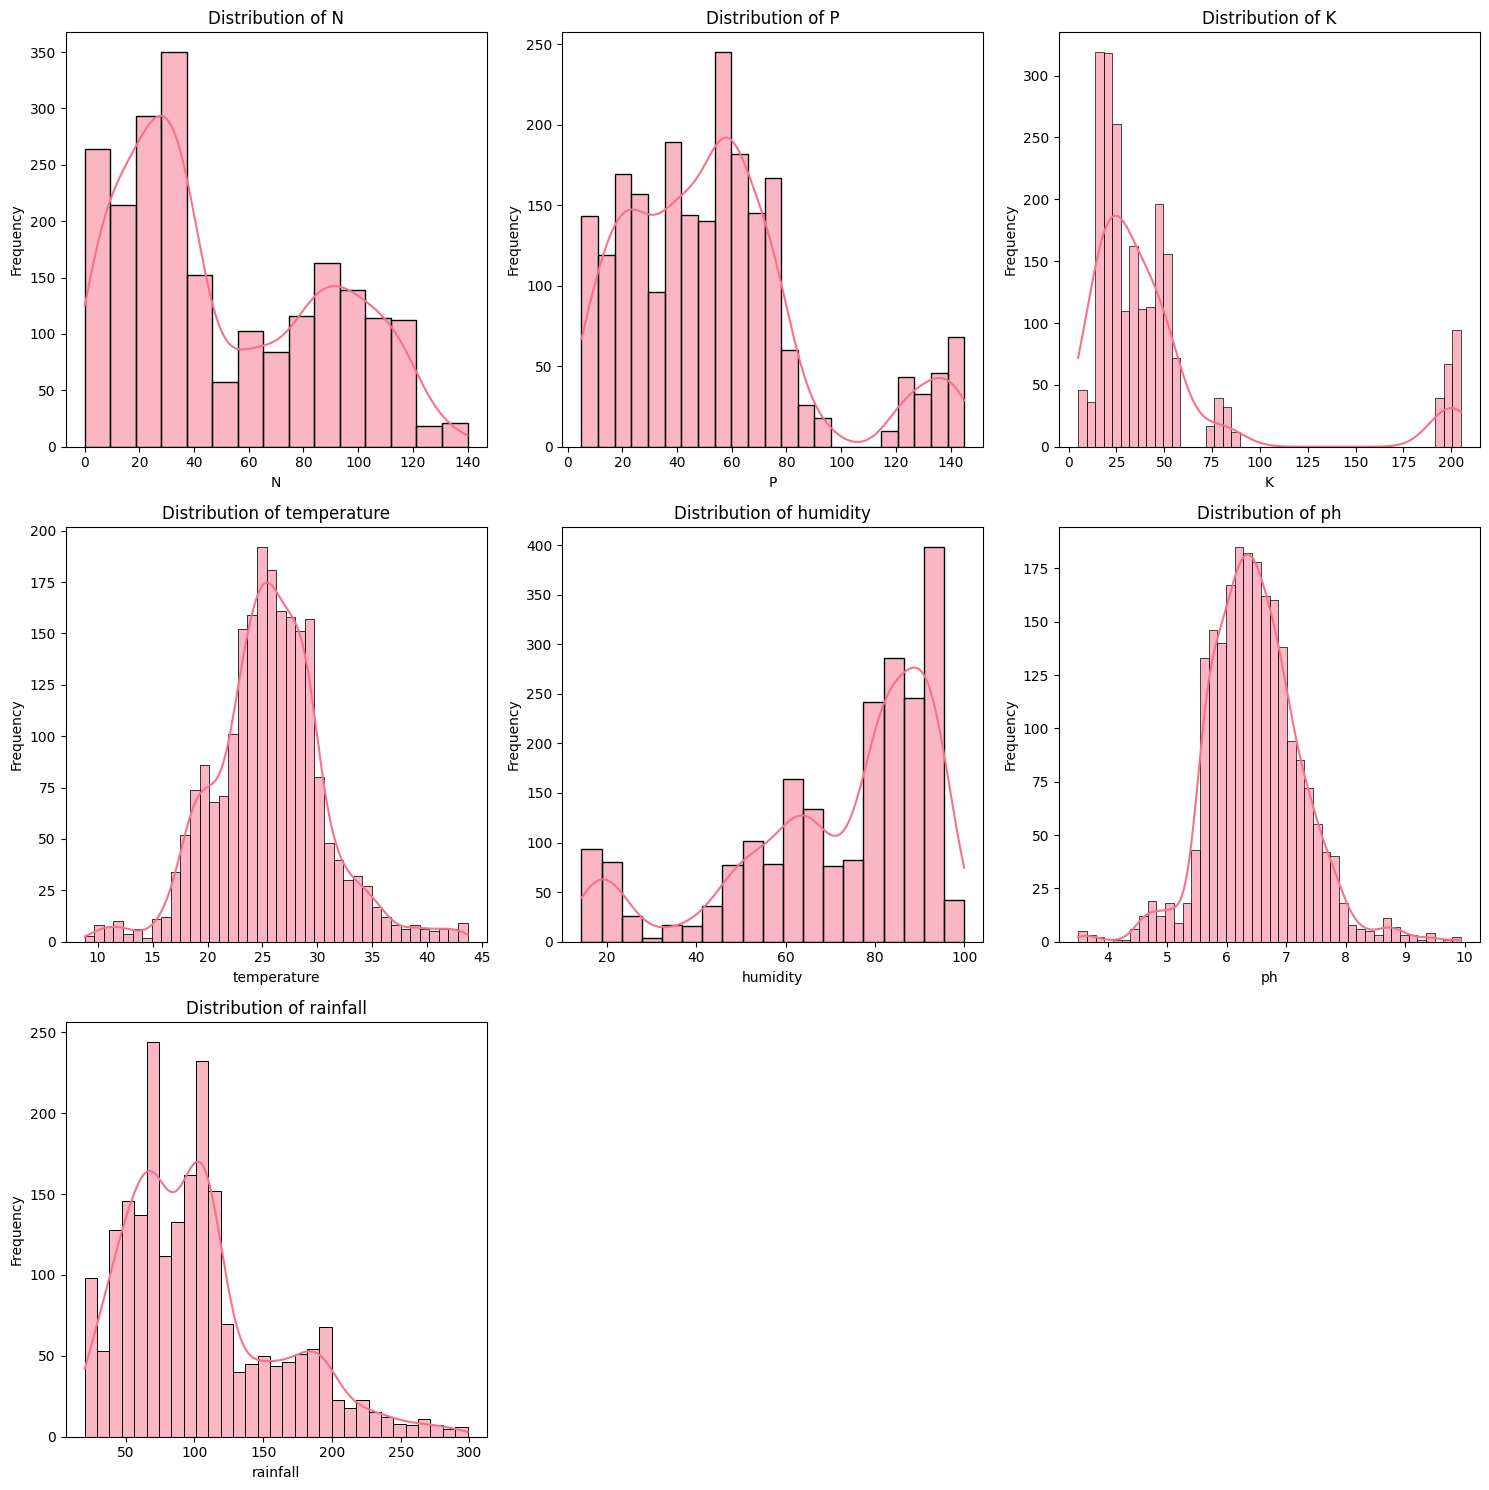


 CORRELATION HEATMAP FOR CROP RECOMMENDATION:


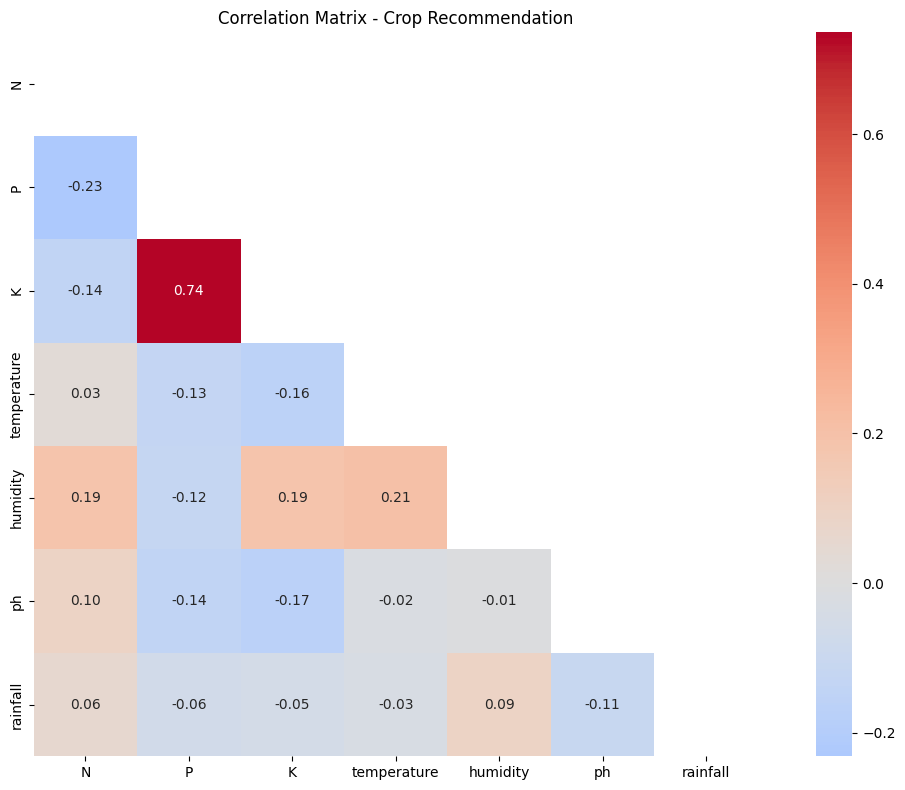

Strong correlations (|r| > 0.7):
  P - K: 0.736

 CROP DISTRIBUTION FOR CROP RECOMMENDATION:


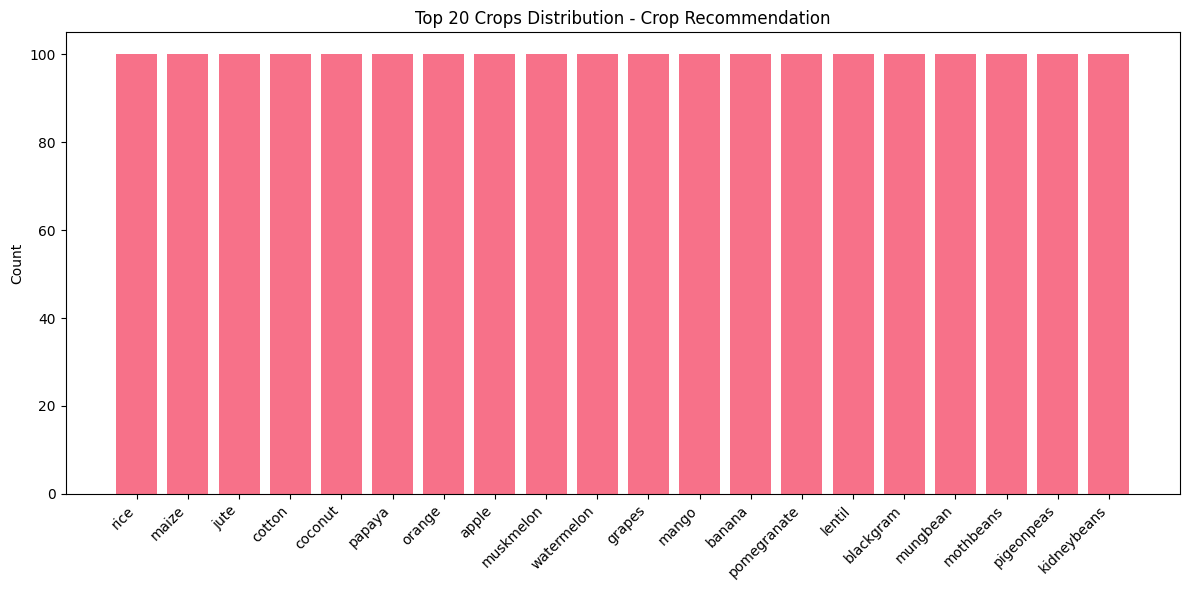

Total unique crops: 22
Most common crop: rice (100 samples)
Least common crop: rice (100 samples)
Class imbalance ratio: 1.00

 FEATURE DISTRIBUTIONS BY CROP FOR CROP RECOMMENDATION:


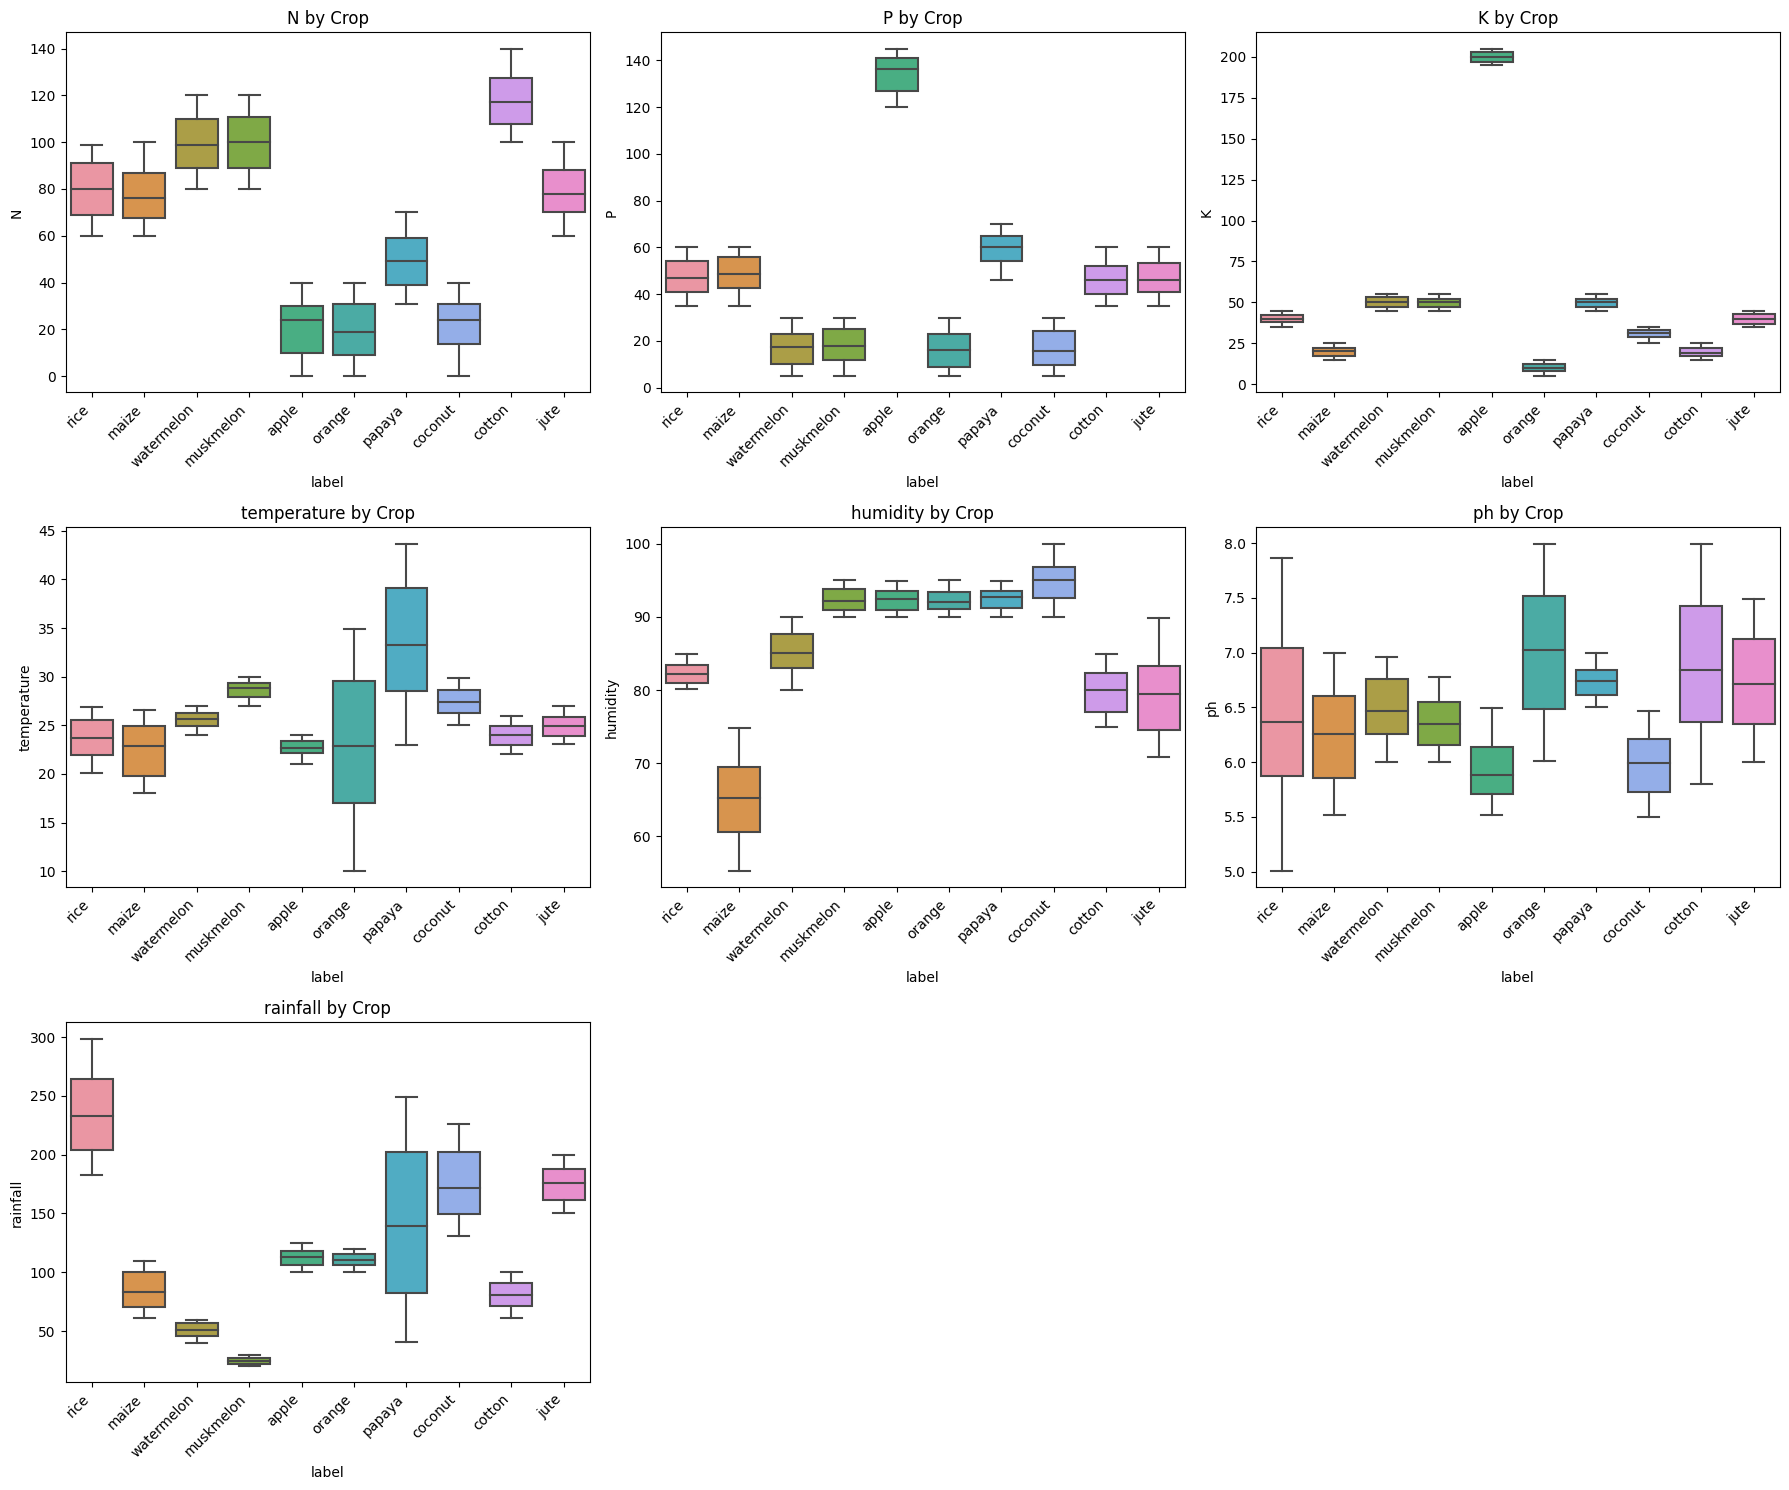


 FEATURE DISTRIBUTIONS FOR CROP PRODUCTION:


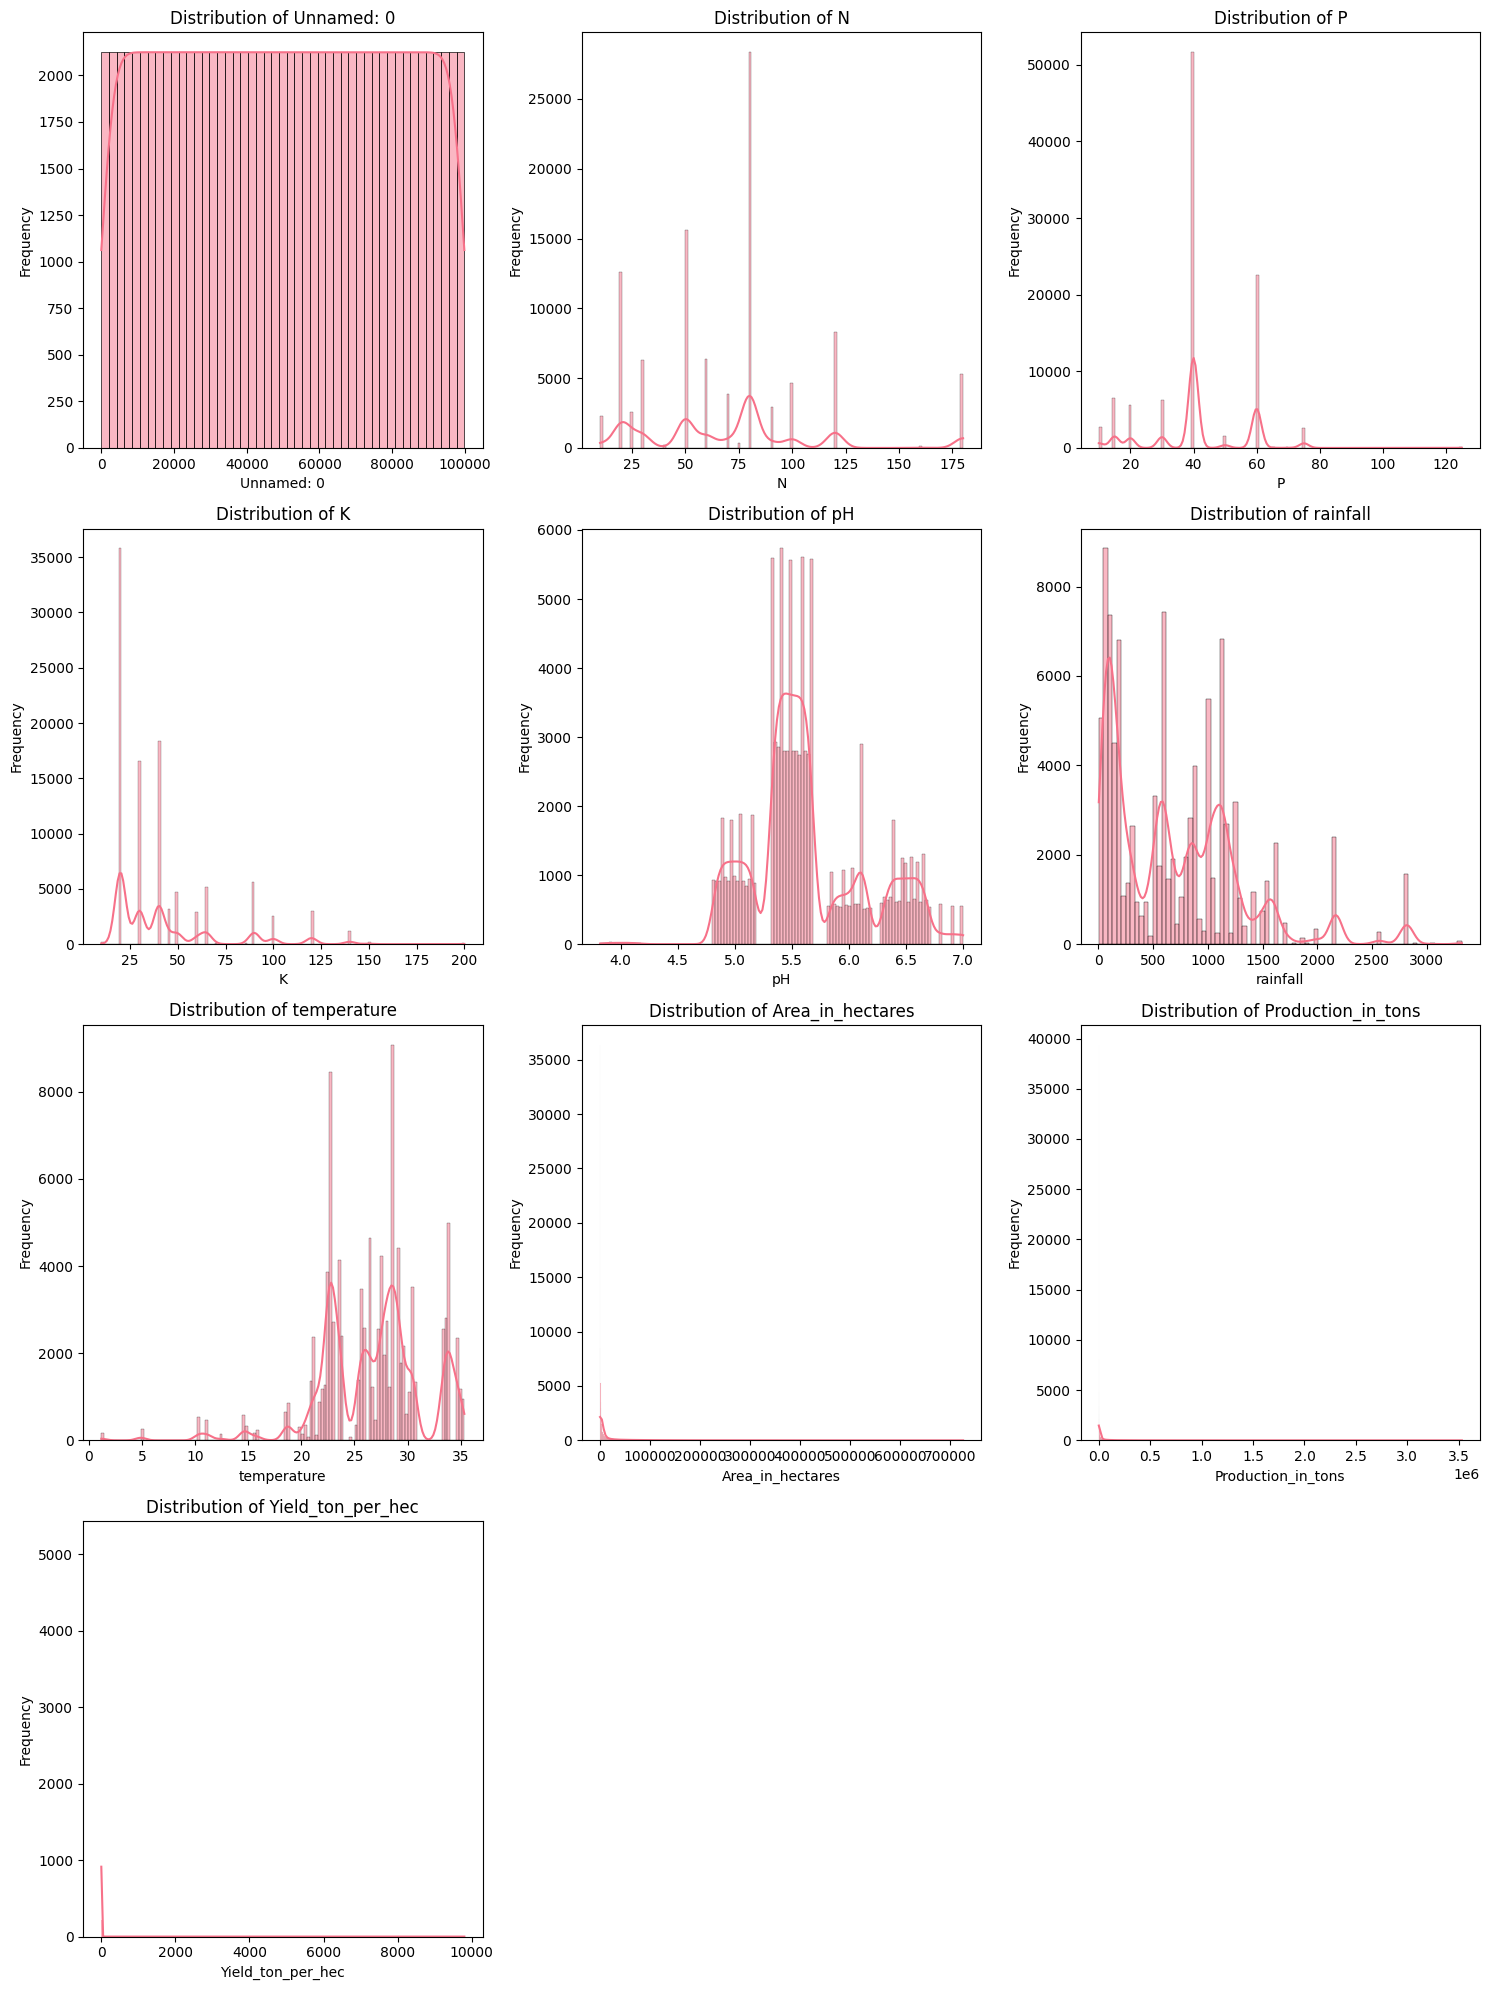


 CORRELATION HEATMAP FOR CROP PRODUCTION:


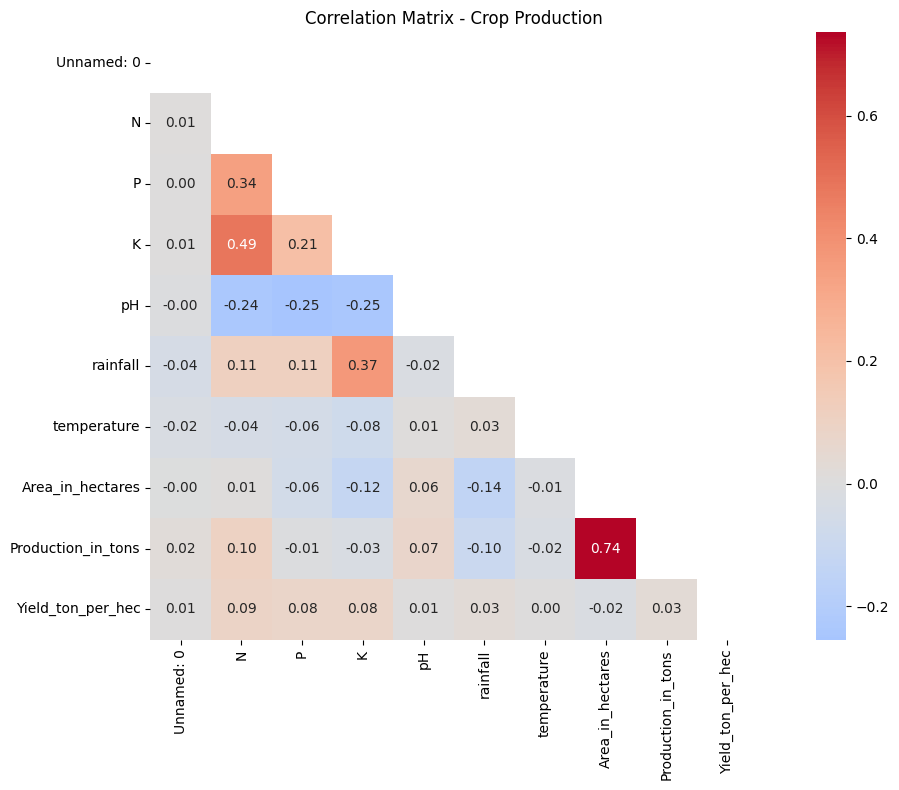

Strong correlations (|r| > 0.7):
  Area_in_hectares - Production_in_tons: 0.736

 CROP DISTRIBUTION FOR CROP PRODUCTION:


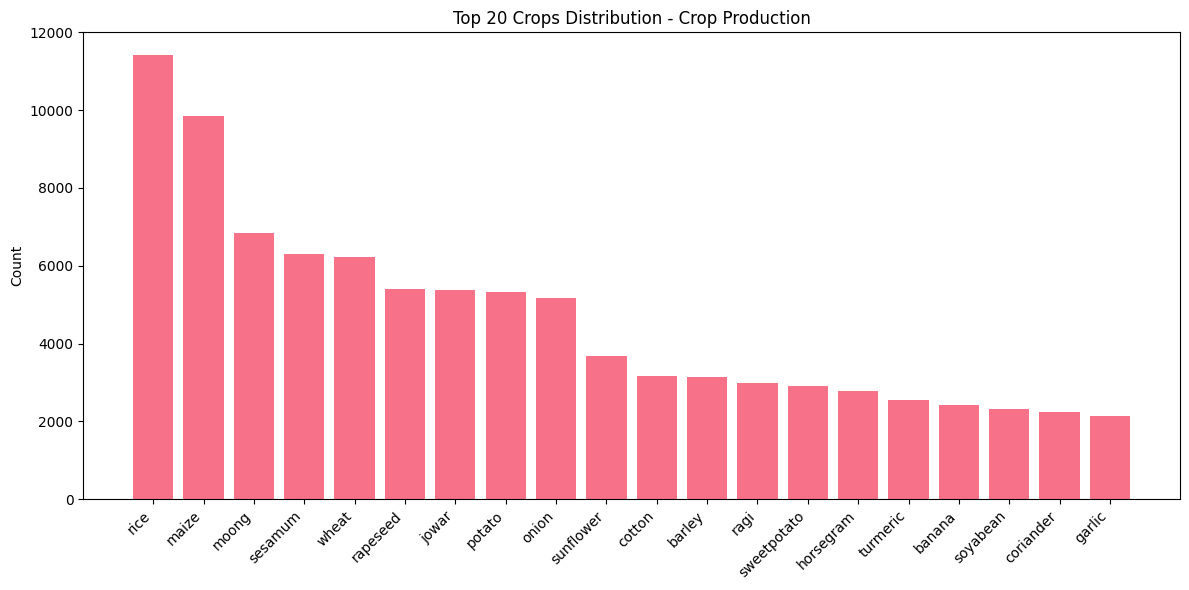

Total unique crops: 53
Most common crop: rice (11430 samples)
Least common crop: apple (3 samples)
Class imbalance ratio: 3810.00

 FEATURE DISTRIBUTIONS BY CROP FOR CROP PRODUCTION:


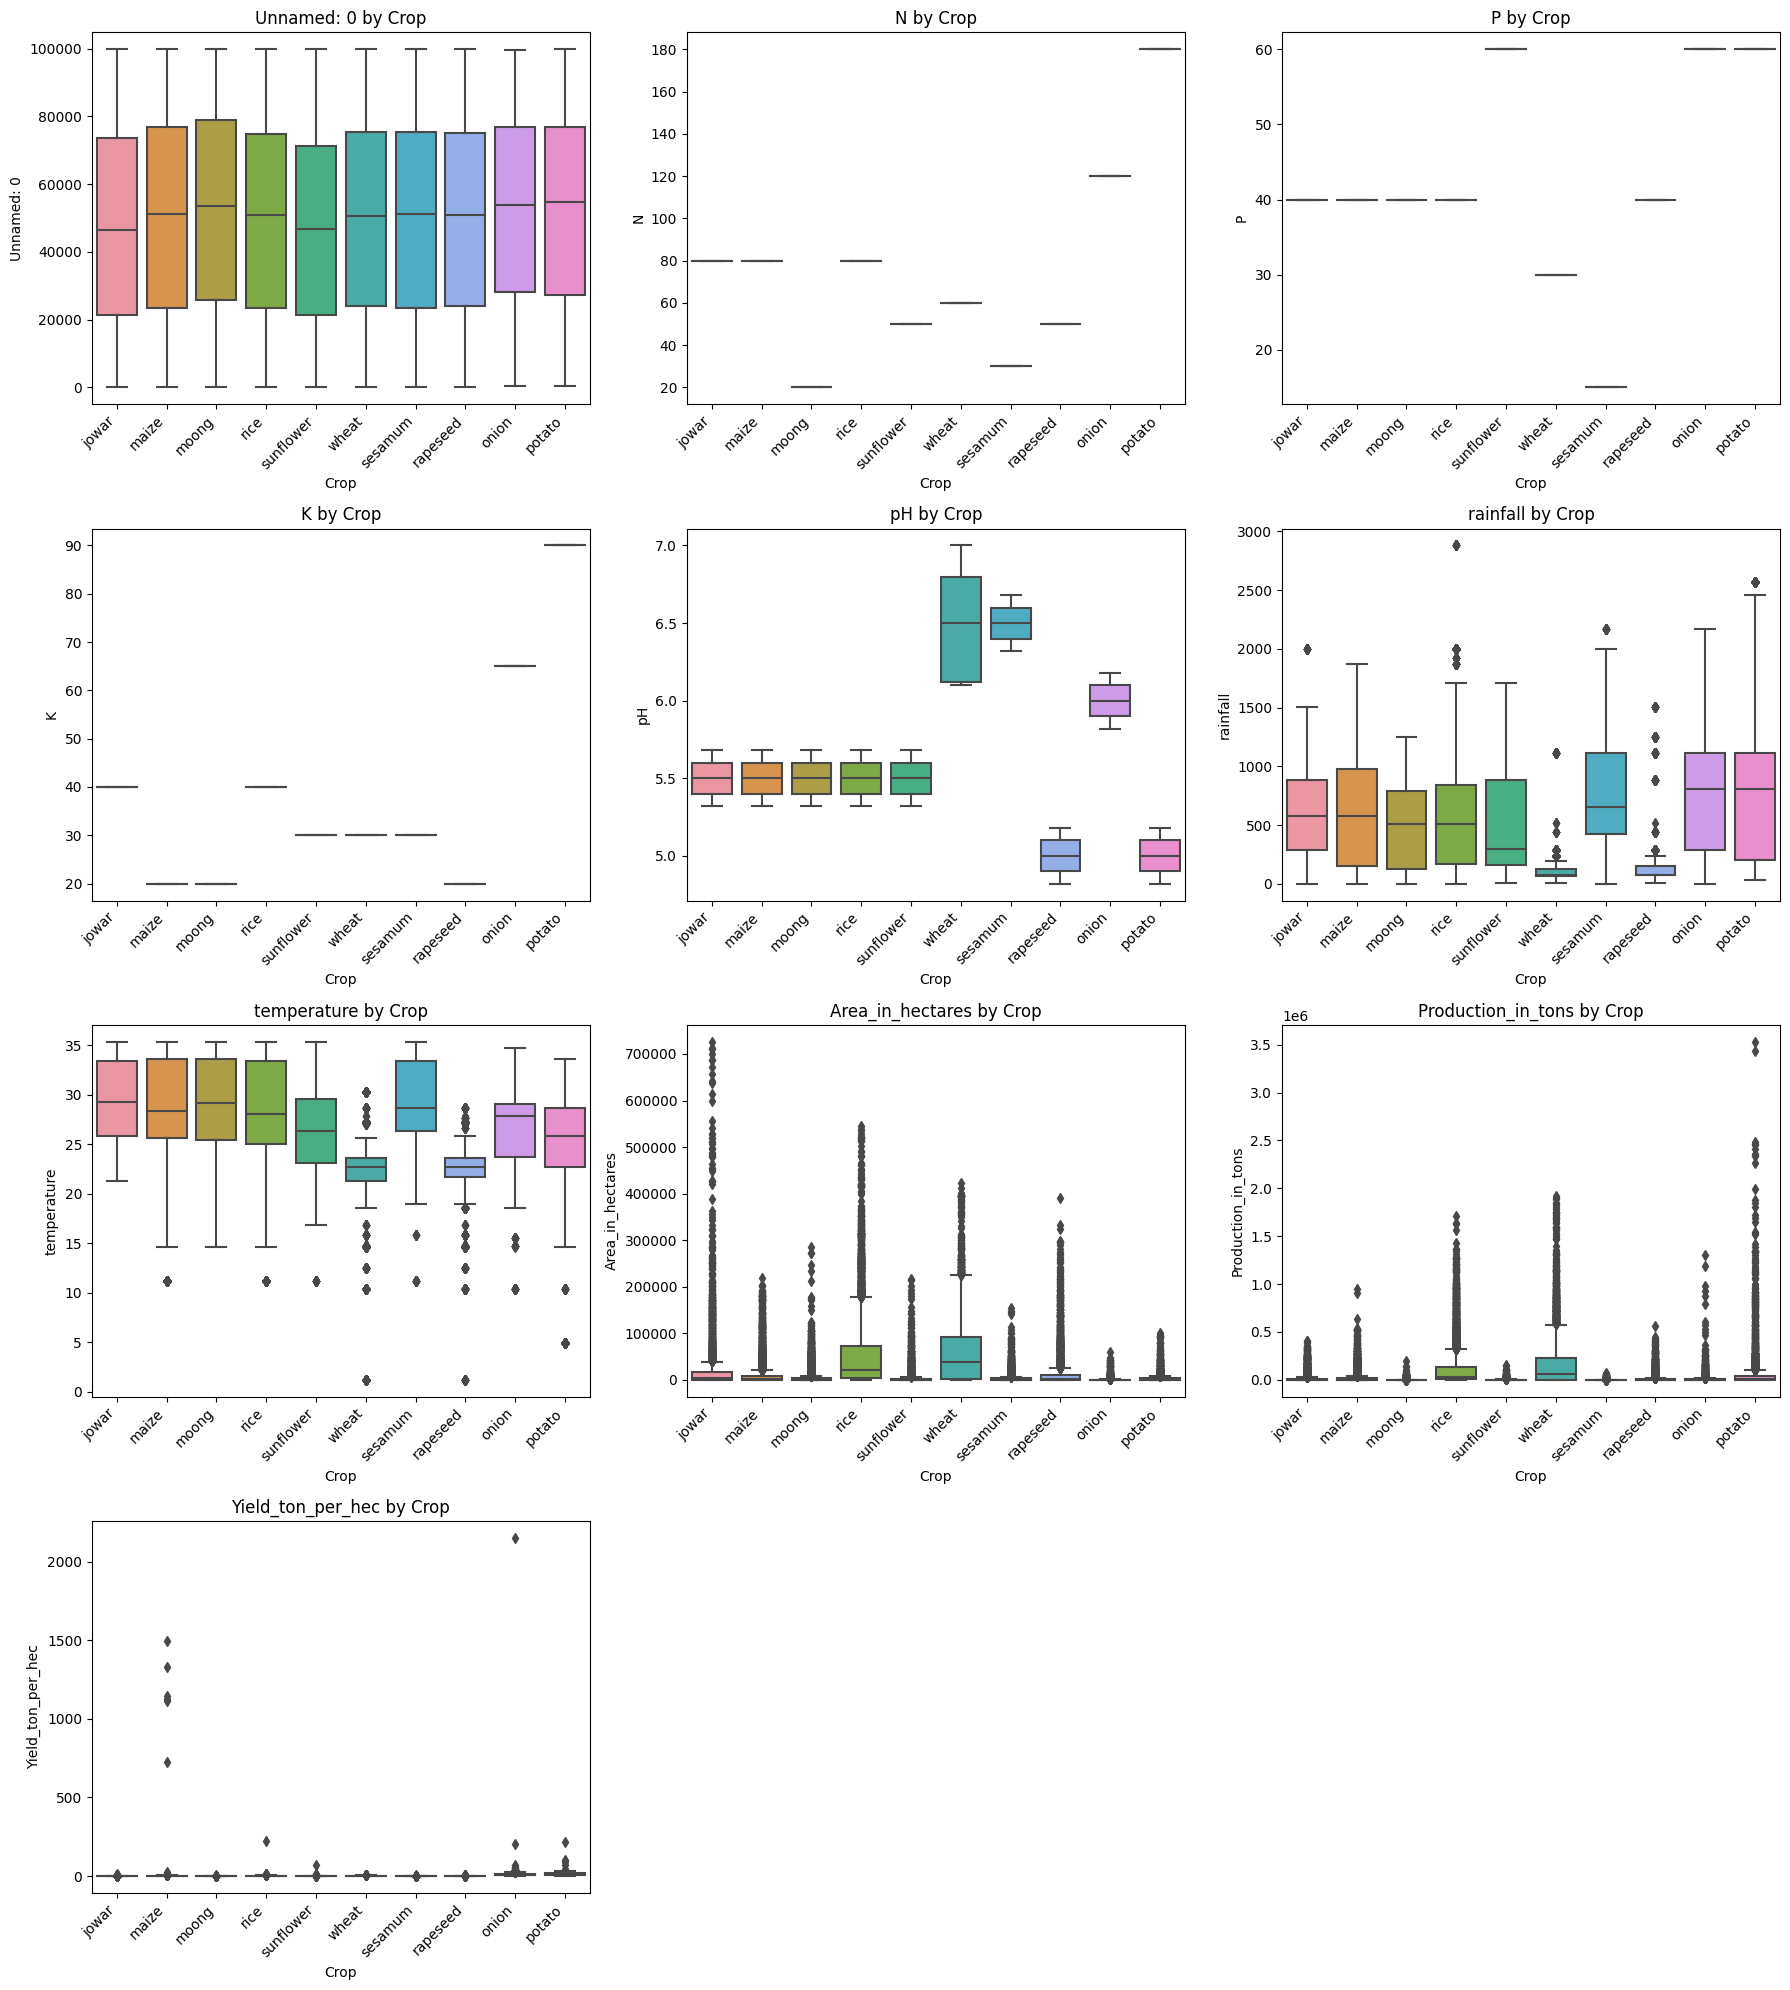


 FEATURE DISTRIBUTIONS FOR SENSOR DATA:


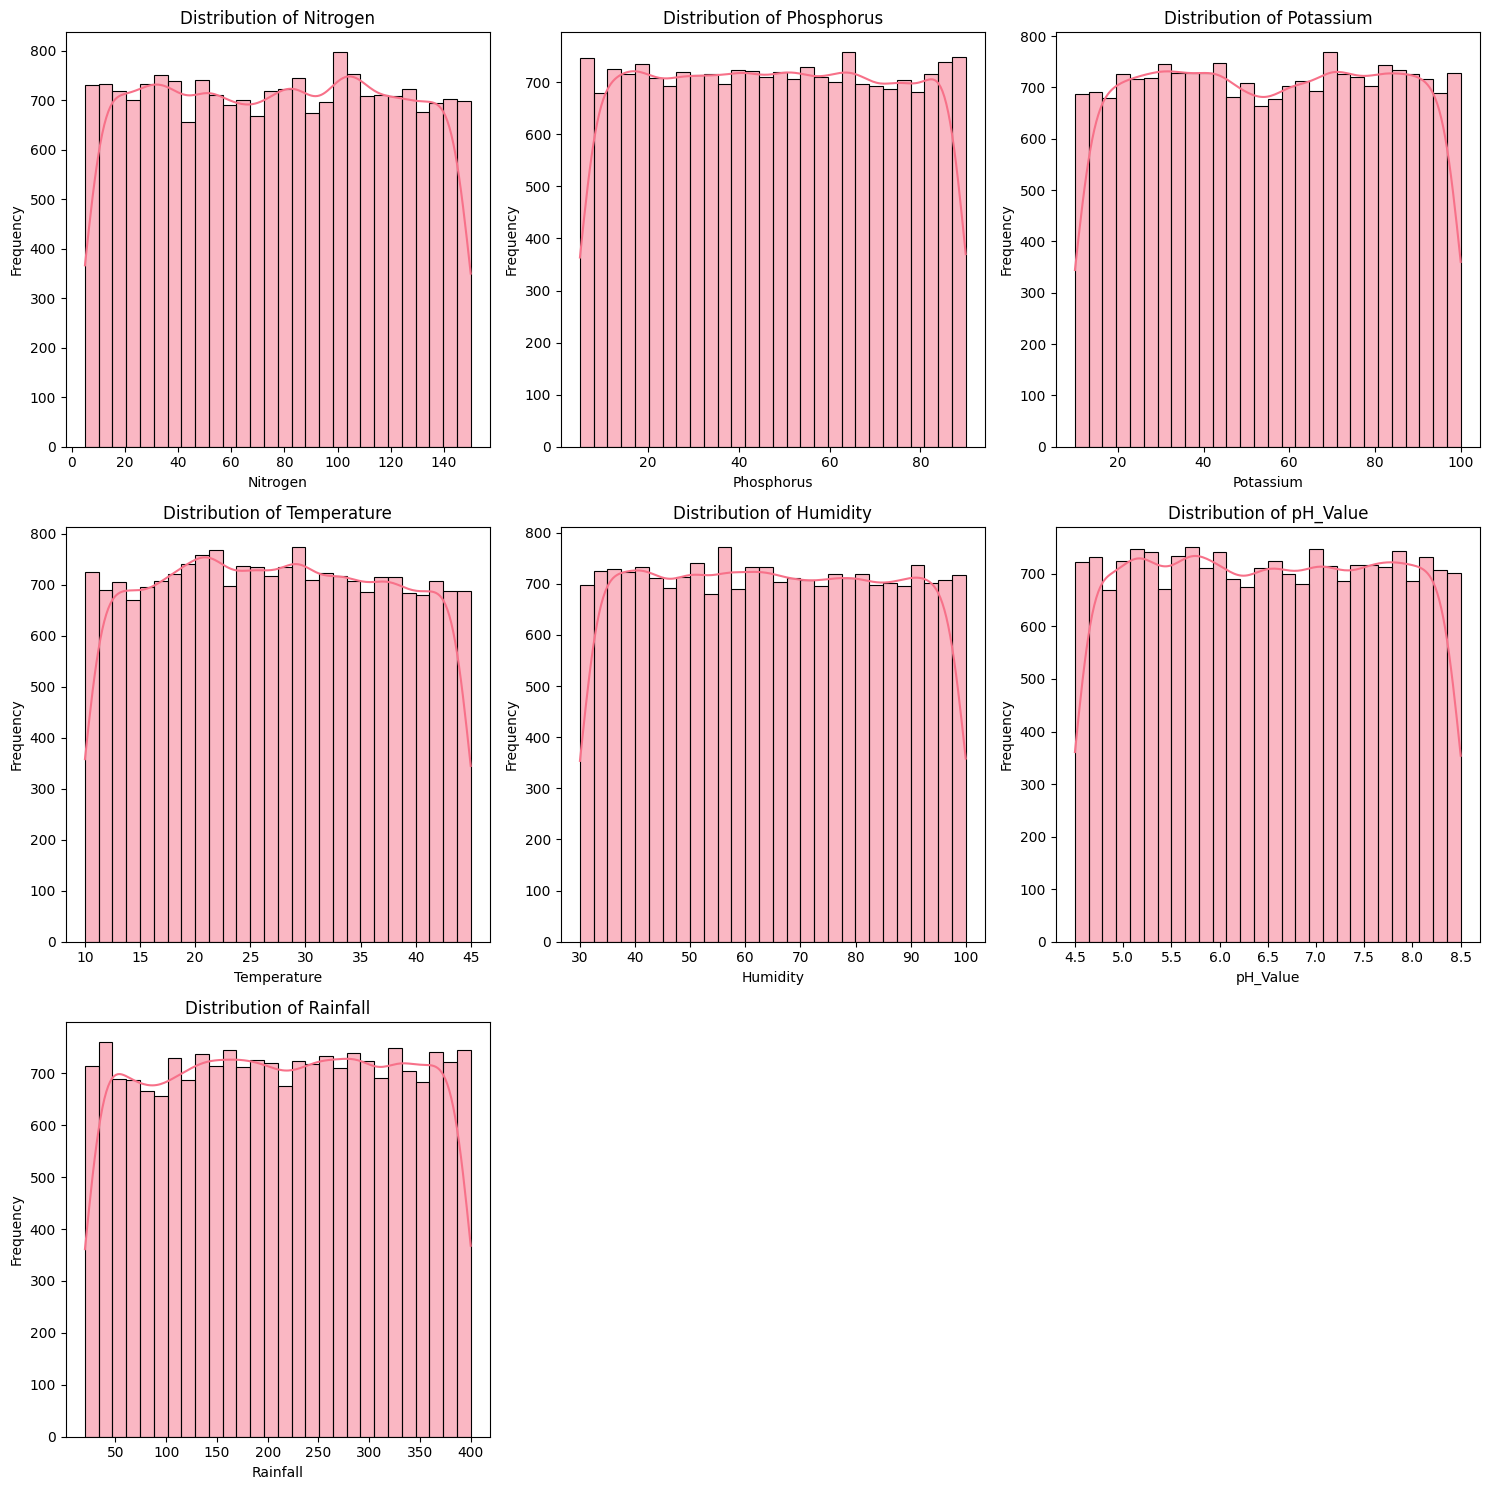


 CORRELATION HEATMAP FOR SENSOR DATA:


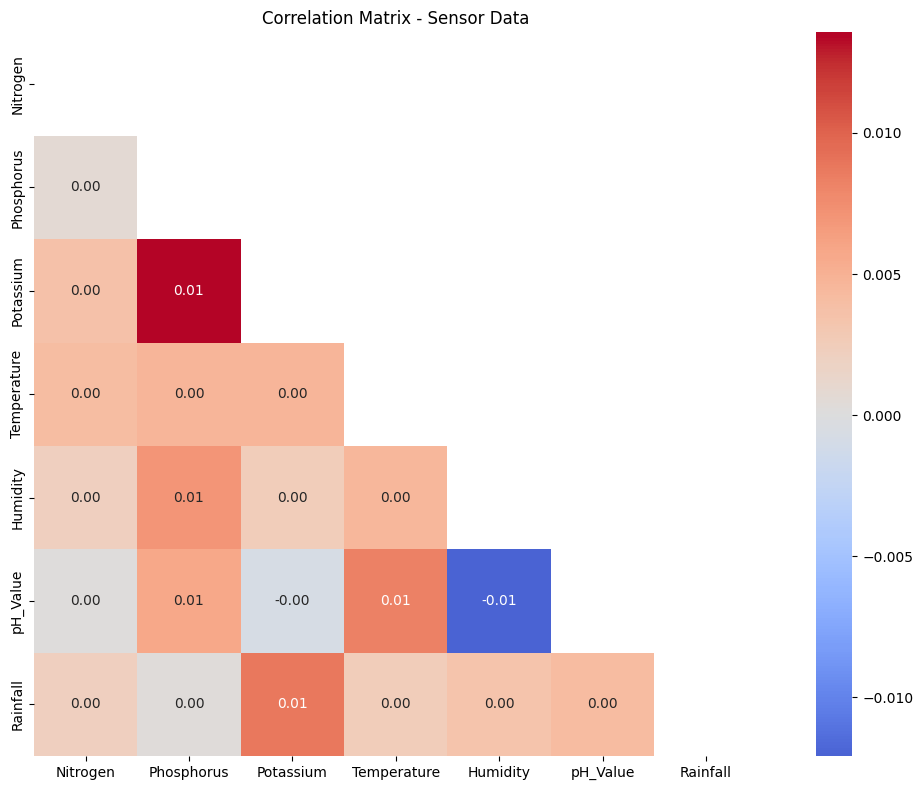

Strong correlations (|r| > 0.7):

 CROP DISTRIBUTION FOR SENSOR DATA:


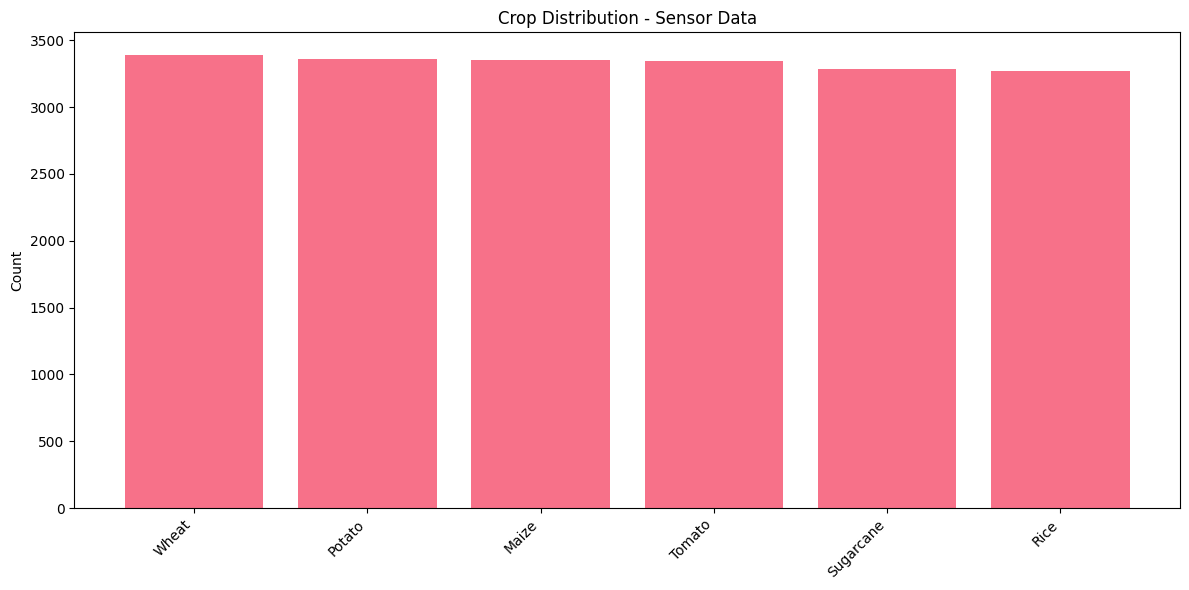

Total unique crops: 6
Most common crop: Wheat (3390 samples)
Least common crop: Rice (3268 samples)
Class imbalance ratio: 1.04

 FEATURE DISTRIBUTIONS BY CROP FOR SENSOR DATA:


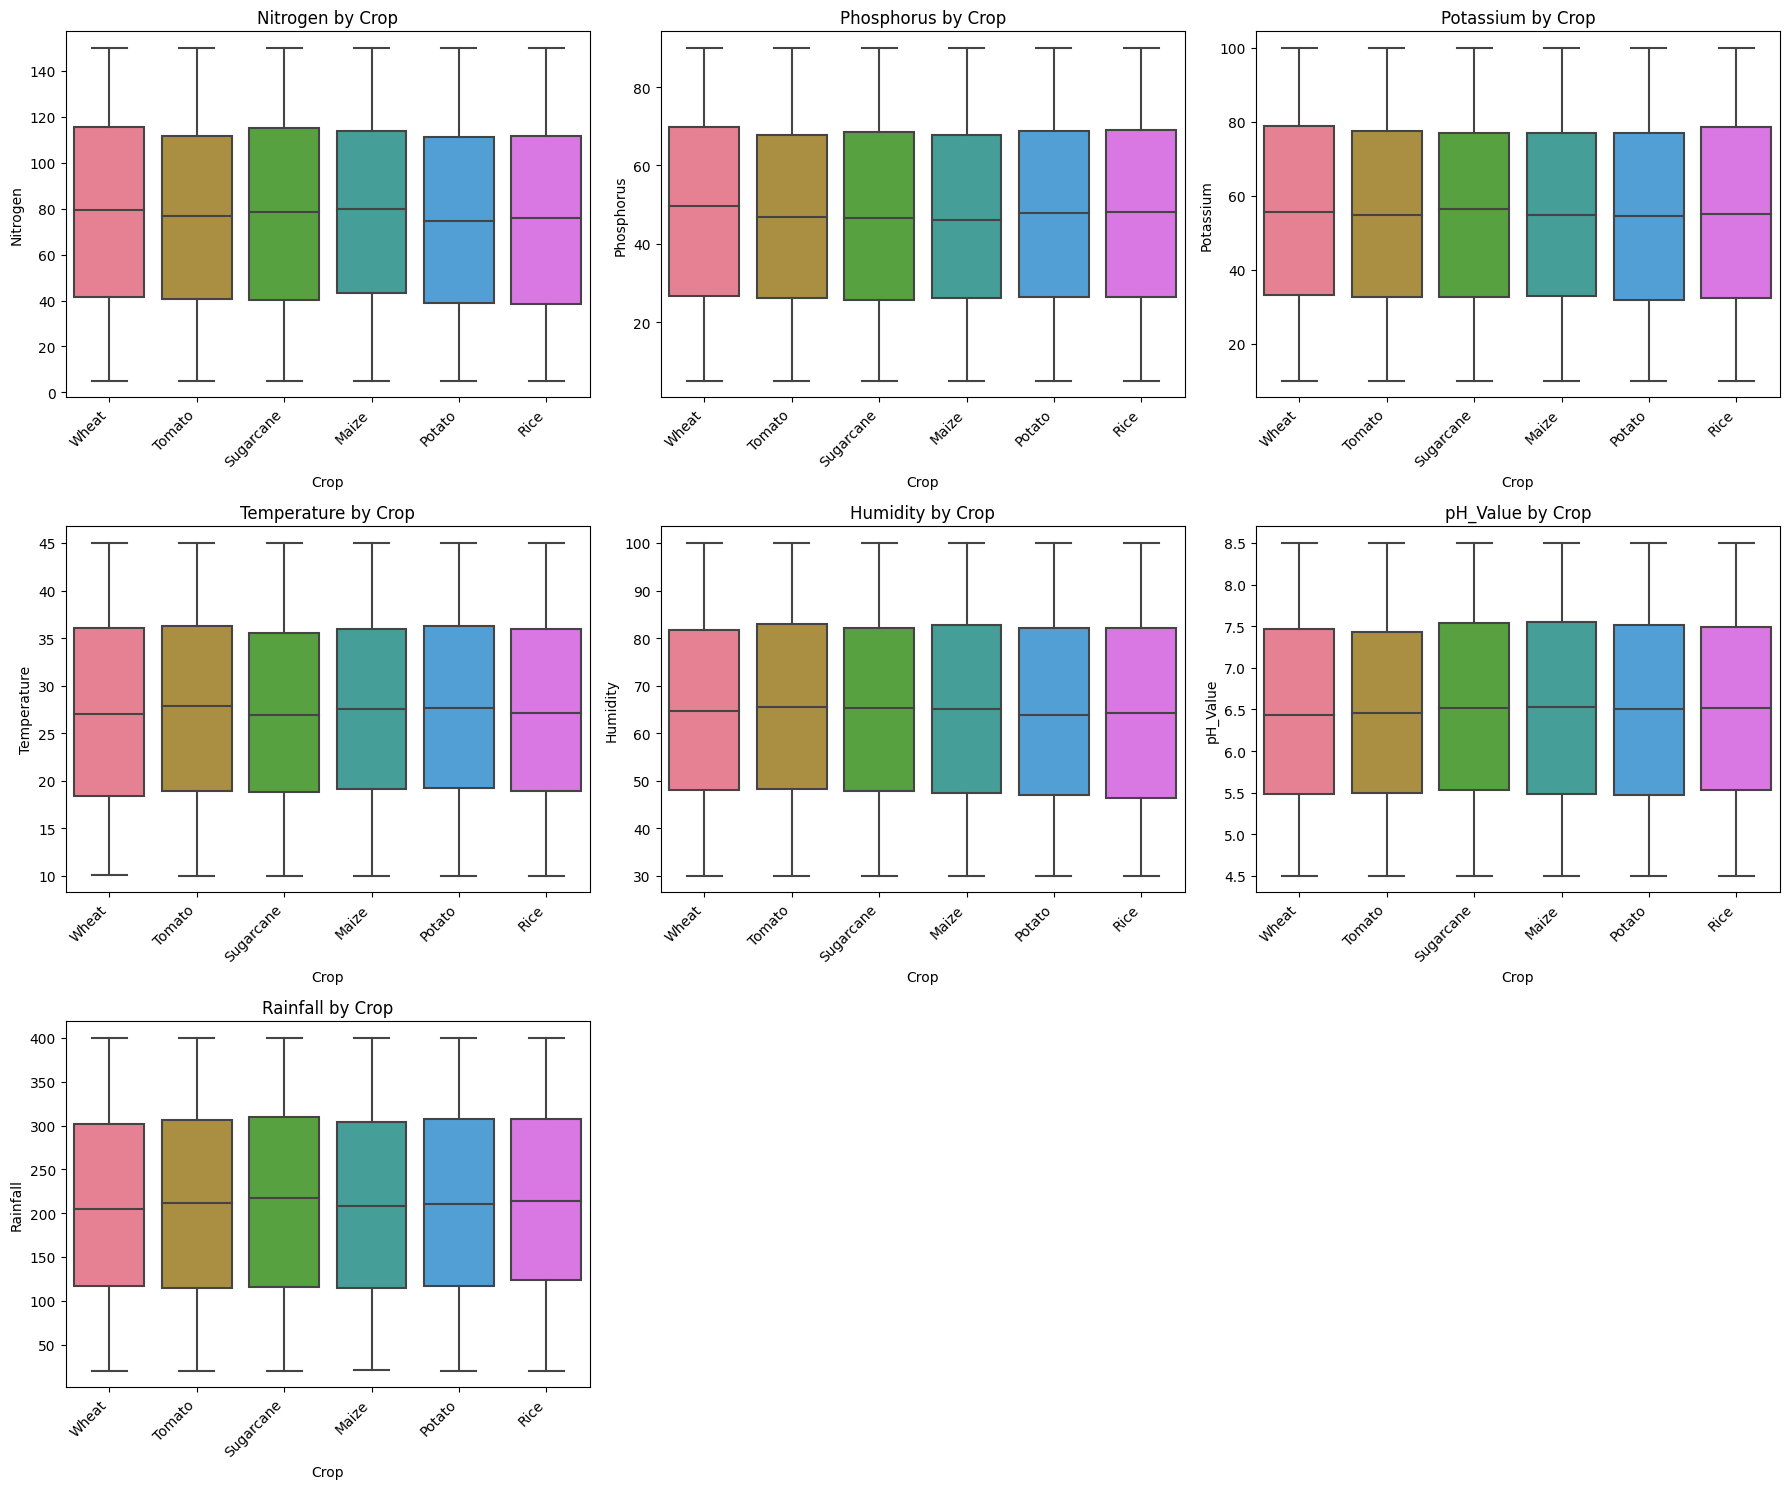

In [8]:
print("\n" + "=" * 80)
print("SECTION 4: DATA VISUALIZATION")
print("=" * 80)

def plot_feature_distributions(df, name):
    """Plot distributions of numerical features."""
    if df is None or df.empty:
        return
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numerical_cols:
        return
    
    print(f"\n FEATURE DISTRIBUTIONS FOR {name.upper()}:")
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df, name):
    """Plot correlation heatmap for numerical features."""
    if df is None or df.empty:
        return
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numerical_cols) < 2:
        return
    
    print(f"\n CORRELATION HEATMAP FOR {name.upper()}:")
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[numerical_cols].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                mask=mask, square=True, fmt='.2f')
    plt.title(f'Correlation Matrix - {name}')
    plt.tight_layout()
    plt.show()
    
    # Print strong correlations
    print("Strong correlations (|r| > 0.7):")
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                strong_corr.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    correlation_matrix.iloc[i, j]
                ))
    
    for corr in strong_corr:
        print(f"  {corr[0]} - {corr[1]}: {corr[2]:.3f}")

def plot_class_distribution(df, name):
    """Plot distribution of crop classes."""
    if df is None or df.empty:
        return
    
    crop_col = None
    for col in ['label', 'Crop', 'crop']:
        if col in df.columns:
            crop_col = col
            break
    
    if crop_col is None:
        return
    
    print(f"\n CROP DISTRIBUTION FOR {name.upper()}:")
    crop_counts = df[crop_col].value_counts()
    
    plt.figure(figsize=(12, 6))
    if len(crop_counts) > 20:
        # Show top 20 crops
        top_crops = crop_counts.head(20)
        bars = plt.bar(range(len(top_crops)), top_crops.values)
        plt.xticks(range(len(top_crops)), top_crops.index, rotation=45, ha='right')
        plt.title(f'Top 20 Crops Distribution - {name}')
    else:
        bars = plt.bar(range(len(crop_counts)), crop_counts.values)
        plt.xticks(range(len(crop_counts)), crop_counts.index, rotation=45, ha='right')
        plt.title(f'Crop Distribution - {name}')
    
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Total unique crops: {len(crop_counts)}")
    print(f"Most common crop: {crop_counts.idxmax()} ({crop_counts.max()} samples)")
    print(f"Least common crop: {crop_counts.idxmin()} ({crop_counts.min()} samples)")
    print(f"Class imbalance ratio: {crop_counts.max()/crop_counts.min():.2f}")

def plot_boxplots(df, name):
    """Plot boxplots for numerical features by crop type."""
    if df is None or df.empty:
        return
    
    crop_col = None
    numerical_cols = []
    for col in ['label', 'Crop', 'crop']:
        if col in df.columns:
            crop_col = col
            numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            numerical_cols = [col for col in numerical_cols if col != crop_col]
            break
    
    if not crop_col or not numerical_cols:
        return
    
    print(f"\n FEATURE DISTRIBUTIONS BY CROP FOR {name.upper()}:")
    
    # Select top 10 crops for better visualization
    top_crops = df[crop_col].value_counts().head(10).index.tolist()
    df_filtered = df[df[crop_col].isin(top_crops)]
    
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            sns.boxplot(x=crop_col, y=col, data=df_filtered, ax=axes[i])
            axes[i].set_title(f'{col} by Crop')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create visualizations for each dataset
for name, df in datasets.items():
    if df is not None:
        plot_feature_distributions(df, name)
        plot_correlation_heatmap(df, name)
        plot_class_distribution(df, name)
        plot_boxplots(df, name)


# FEATURE ENGINEERING

In [9]:
print("\n" + "=" * 80)
print("SECTION 5: FEATURE ENGINEERING")
print("=" * 80)

def feature_engineer_consistent(df, dataset_name=""):
    """Feature engineering that produces only the 10 core features."""
    if df is None or df.empty:
        print(f"No data available for {dataset_name}")
        return pd.DataFrame()
    
    df = df.copy()
    print(f"\n🔧 FEATURE ENGINEERING FOR {dataset_name.upper()}:")
    print(f"Initial shape: {df.shape}")
    
    # Ensure we have the required columns
    required_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    for col in required_cols:
        if col not in df.columns:
            df[col] = np.nan
            print(f"  Added missing column: {col}")
    
    # Fill missing values with medians
    numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    for col in numeric_cols:
        if col in df.columns and df[col].isna().any():
            na_count = df[col].isna().sum()
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  Filled {na_count} NaN values in {col} with median: {median_val:.2f}")
    
    # Create the 10 core features
    # 8. log_rainfall
    if 'rainfall' in df.columns:
        df['log_rainfall'] = np.log1p(df['rainfall'])
        print("  Created feature: log_rainfall")
    
    # 9. npk_sum
    if all(col in df.columns for col in ['N', 'P', 'K']):
        df['npk_sum'] = df[['N', 'P', 'K']].sum(axis=1)
        print("  Created feature: npk_sum")
    
    # 10. ph_bin_enc
    if 'ph' in df.columns:
        df['ph'] = df['ph'].fillna(df['ph'].median())
        df['ph_bin'] = pd.cut(
            df['ph'], 
            bins=[0, 5.5, 6.5, 7.5, 14], 
            labels=['acidic', 'slightly_acidic', 'neutral', 'alkaline']
        )
        le_ph = LabelEncoder()
        df['ph_bin'] = df['ph_bin'].fillna('neutral')
        df['ph_bin_enc'] = le_ph.fit_transform(df['ph_bin'].astype(str))
        print("  Created feature: ph_bin_enc")
    
    # Keep only the 10 core features + label if present
    keep_cols = [col for col in CORE_FEATURES if col in df.columns]
    if 'label' in df.columns:
        keep_cols.append('label')
        df['label'] = df['label'].str.lower().str.strip()
    
    # Fill any remaining NaN values with medians
    numeric_cols = [col for col in keep_cols if col != 'label' and df[col].dtype.kind in 'fi']
    for col in numeric_cols:
        if col in df.columns and df[col].isna().any():
            na_count = df[col].isna().sum()
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  Filled {na_count} remaining NaN values in {col}")
    
    result = df[keep_cols]
    print(f"Final shape: {result.shape}")
    print(f"Final columns: {list(result.columns)}")
    
    return result

# Apply feature engineering to each dataset
crop_rec_fe = feature_engineer_consistent(crop_rec, "Crop Recommendation")
crop_prod_fe = feature_engineer_consistent(crop_prod, "Crop Production")
sensor_fe = feature_engineer_consistent(sensor_df, "Sensor Data")


SECTION 5: FEATURE ENGINEERING

🔧 FEATURE ENGINEERING FOR CROP RECOMMENDATION:
Initial shape: (2200, 8)
  Created feature: log_rainfall
  Created feature: npk_sum
  Created feature: ph_bin_enc
Final shape: (2200, 11)
Final columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'log_rainfall', 'npk_sum', 'ph_bin_enc', 'label']

🔧 FEATURE ENGINEERING FOR CROP PRODUCTION:
Initial shape: (99849, 13)
  Added missing column: humidity
  Filled 99849 NaN values in humidity with median: nan
  Created feature: log_rainfall
  Created feature: npk_sum
  Created feature: ph_bin_enc
  Filled 99849 remaining NaN values in humidity
Final shape: (99849, 11)
Final columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'log_rainfall', 'npk_sum', 'ph_bin_enc', 'label']

🔧 FEATURE ENGINEERING FOR SENSOR DATA:
Initial shape: (20000, 10)
  Created feature: log_rainfall
  Created feature: npk_sum
  Created feature: ph_bin_enc
Final shape: (20000, 11)
Final columns: ['N', 'P', 'K

# DATA MERGING AND OUTLIER DETECTION

In [10]:
print("\n" + "=" * 80)
print("SECTION 6: DATA MERGING AND OUTLIER DETECTION")
print("=" * 80)

# Merge datasets
dataframes = [df for df in [crop_rec_fe, crop_prod_fe, sensor_fe] if not df.empty]
if not dataframes:
    print(" Error: No valid DataFrames to concatenate")
else:
    merged = pd.concat(dataframes, ignore_index=True, sort=False)
    print(f" Merged dataset shape: {merged.shape}")
    print(f" Merged dataset columns: {list(merged.columns)}")
    
    # Check for and handle any remaining NaN values in the target
    if merged['label'].isna().any():
        na_count = merged['label'].isna().sum()
        print(f"  Dropping {na_count} rows with NaN labels")
        merged = merged.dropna(subset=['label'])
    
    print(f" Dataset after label cleaning: {merged.shape}")

def detect_outliers_iforest(df, contamination=0.05):
    """Detect outliers using Isolation Forest with proper NaN handling."""
    if df.empty:
        return []
    
    numeric_cols = [col for col in CORE_FEATURES if col in df.columns and df[col].dtype.kind in 'fi']
    if not numeric_cols:
        return []
    
    print(f"\n OUTLIER DETECTION USING ISOLATION FOREST:")
    print(f"Features used: {numeric_cols}")
    
    # Check for and handle NaN values
    if df[numeric_cols].isna().any().any():
        na_count = df[numeric_cols].isna().sum().sum()
        print(f"  Found {na_count} NaN values in features. Imputing with median values.")
        imputer = SimpleImputer(strategy='median')
        X_imputed = imputer.fit_transform(df[numeric_cols])
        df_imputed = pd.DataFrame(X_imputed, columns=numeric_cols, index=df.index)
    else:
        df_imputed = df[numeric_cols]
    
    iso = IsolationForest(contamination=contamination, random_state=RANDOM_STATE)
    preds = iso.fit_predict(df_imputed)
    outlier_indices = df.index[preds == -1].tolist()
    print(f" IsolationForest detected {len(outlier_indices)} outliers ({len(outlier_indices)/len(df)*100:.2f}%)")
    
    return outlier_indices

# Detect outliers
outliers = detect_outliers_iforest(merged)
if outliers:
    print(f"  Removing {len(outliers)} outliers from the dataset")
    merged = merged.drop(index=outliers, errors='ignore')
    print(f" Dataset after outlier removal: {merged.shape}")



SECTION 6: DATA MERGING AND OUTLIER DETECTION
 Merged dataset shape: (122049, 11)
 Merged dataset columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'log_rainfall', 'npk_sum', 'ph_bin_enc', 'label']
 Dataset after label cleaning: (122049, 11)

 OUTLIER DETECTION USING ISOLATION FOREST:
Features used: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'log_rainfall', 'npk_sum', 'ph_bin_enc']
  Found 99849 NaN values in features. Imputing with median values.
 IsolationForest detected 6103 outliers (5.00%)
  Removing 6103 outliers from the dataset
 Dataset after outlier removal: (115946, 11)


# FINAL DATA PREPARATION

In [11]:
print("\n" + "=" * 80)
print("SECTION 7: FINAL DATA PREPARATION")
print("=" * 80)

# Encode target
label_encoder = LabelEncoder()
merged['label_enc'] = label_encoder.fit_transform(merged['label'])

print(f" Target encoding completed. {len(label_encoder.classes_)} unique classes:")
for i, class_name in enumerate(label_encoder.classes_):
    count = (merged['label_enc'] == i).sum()
    print(f"  {class_name}: {count} samples")

# Prepare features and target
X = merged[CORE_FEATURES].copy()
y = merged['label_enc'].copy()

print(f"\n FINAL FEATURE MATRIX:")
print(f"Shape: {X.shape}")
print(f"Features: {list(X.columns)}")

# Check for and handle any remaining NaN values in features
if X.isna().any().any():
    na_count = X.isna().sum().sum()
    print(f"  Found {na_count} remaining NaN values in features. Imputing with median values.")
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)
else:
    print(" No NaN values found in features")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

print(f"\n TRAINING/TESTING SPLIT:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in testing: {np.bincount(y_test)}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n FEATURE STANDARDIZATION COMPLETED")


SECTION 7: FINAL DATA PREPARATION
 Target encoding completed. 60 unique classes:
  arecanut: 948 samples
  ashgourd: 28 samples
  banana: 2509 samples
  barley: 3139 samples
  beetroot: 14 samples
  bittergourd: 67 samples
  blackgram: 158 samples
  blackpepper: 571 samples
  bottlegourd: 58 samples
  brinjal: 282 samples
  cabbage: 125 samples
  cardamom: 172 samples
  carrot: 28 samples
  cashewnuts: 732 samples
  cauliflower: 105 samples
  chickpea: 13 samples
  coconut: 70 samples
  coffee: 106 samples
  coriander: 2253 samples
  cotton: 3257 samples
  cucumber: 72 samples
  drumstick: 73 samples
  garlic: 2138 samples
  ginger: 18 samples
  horsegram: 2784 samples
  jackfruit: 90 samples
  jowar: 5369 samples
  jute: 1158 samples
  kidneybeans: 15 samples
  ladyfinger: 217 samples
  lentil: 100 samples
  maize: 12538 samples
  mango: 424 samples
  moong: 6855 samples
  mothbeans: 97 samples
  mungbean: 95 samples
  muskmelon: 47 samples
  onion: 5164 samples
  orange: 123 samples

# MODEL TRAINING AND EVALUATION


SECTION 8: MODEL TRAINING AND EVALUATION
  CLASS WEIGHTS CALCULATED:
  arecanut: 2.038
  ashgourd: 69.015
  banana: 0.770
  barley: 0.616
  beetroot: 131.756
  bittergourd: 28.986
  blackgram: 12.282
  blackpepper: 3.386
  bottlegourd: 32.939
  brinjal: 6.869
  cabbage: 15.418
  cardamom: 11.235
  carrot: 69.015
  cashewnuts: 2.640
  cauliflower: 18.346
  chickpea: 144.932
  coconut: 27.346
  coffee: 18.116
  coriander: 0.858
  cotton: 0.593
  cucumber: 26.839
  drumstick: 26.351
  garlic: 0.904
  ginger: 103.523
  horsegram: 0.694
  jackfruit: 21.313
  jowar: 0.360
  jute: 1.670
  kidneybeans: 131.756
  ladyfinger: 8.892
  lentil: 19.324
  maize: 0.154
  mango: 4.558
  moong: 0.282
  mothbeans: 19.854
  mungbean: 20.413
  muskmelon: 41.409
  onion: 0.374
  orange: 15.753
  papaya: 5.103
  pigeonpeas: 20.413
  pineapple: 45.291
  pomegranate: 19.324
  potato: 0.250
  pumpkin: 51.761
  radish: 42.627
  ragi: 0.645
  rapeseed: 0.357
  rice: 0.138
  ridgegourd: 90.582
  sesamum: 0.307
  

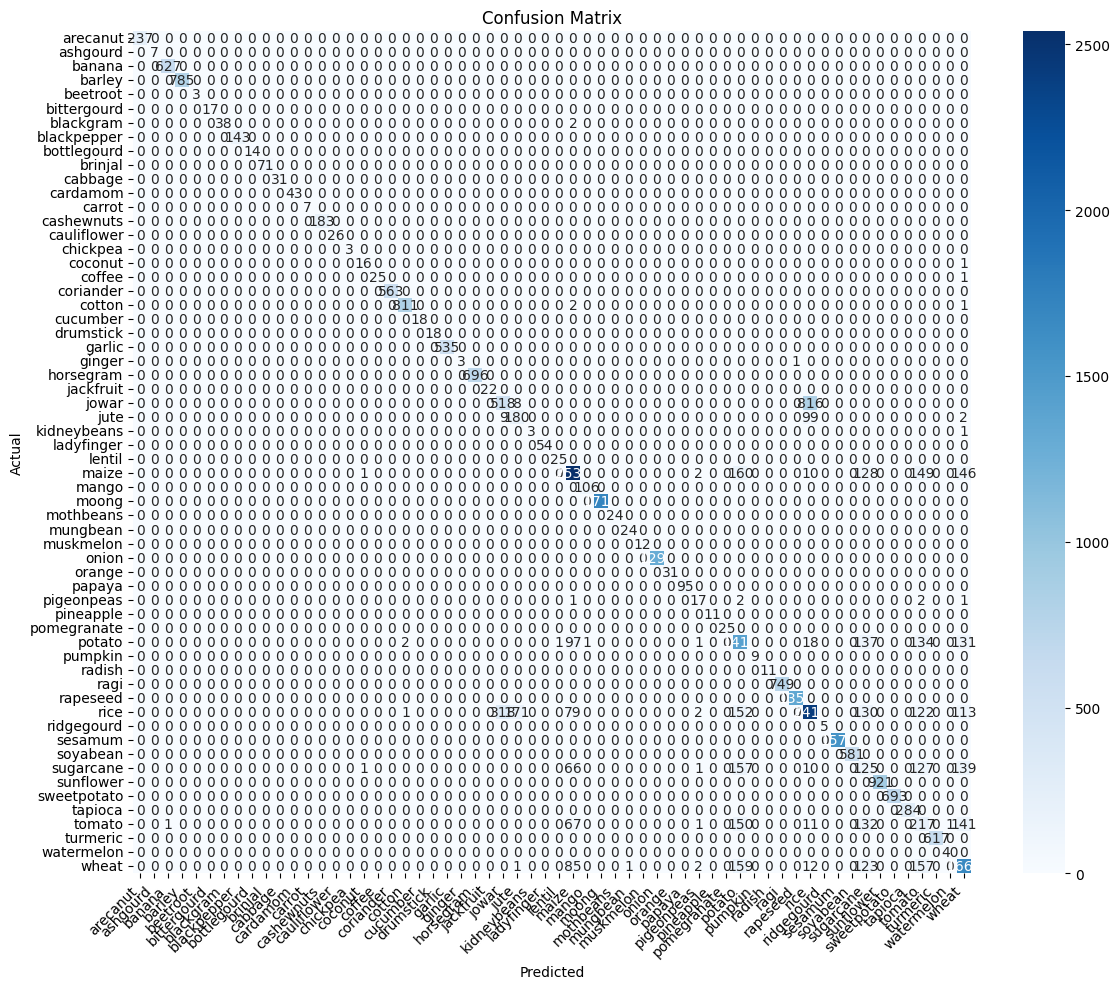

In [12]:
print("\n" + "=" * 80)
print("SECTION 8: MODEL TRAINING AND EVALUATION")
print("=" * 80)

# Calculate class weights
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_map = dict(zip(classes, weights))
sample_weights = np.array([class_weight_map[c] for c in y_train])

print(f"  CLASS WEIGHTS CALCULATED:")
for cls, weight in class_weight_map.items():
    class_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {class_name}: {weight:.3f}")

# Train XGBoost model
print(f"\n TRAINING XGBOOST MODEL...")
model = XGBClassifier(
    objective='multi:softprob', 
    max_depth=4, 
    n_estimators=200,
    learning_rate=0.05, 
    random_state=RANDOM_STATE,
    eval_metric='mlogloss'
)

model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
print(" Model training completed")

# Calibrate model
print(f"\n CALIBRATING MODEL...")
calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated_model.fit(X_train_scaled, y_train)
print(" Model calibration completed")

# Evaluate
y_pred = calibrated_model.predict(X_test_scaled)
y_prob = calibrated_model.predict_proba(X_test_scaled)

# Calculate metrics
final_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    'f1_macro': f1_score(y_test, y_pred, average='macro'),
    'f1_weighted': f1_score(y_test, y_pred, average='weighted')
}

print(f"\n MODEL PERFORMANCE METRICS:")
print("-" * 40)
for metric, value in final_metrics.items():
    print(f"{metric:20}: {value:.4f}")

# Generate classification report
print(f"\n CLASSIFICATION REPORT:")
print("-" * 40)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# MODEL SAVING AND DEPLOYMENT PREPARATION

In [13]:
print("\n" + "=" * 80)
print("SECTION 9: MODEL SAVING AND DEPLOYMENT PREPARATION")
print("=" * 80)

# Save artifacts
artifacts = {
    'model.joblib': calibrated_model,
    'scaler.joblib': scaler,
    'label_encoder.joblib': label_encoder,
    'feature_names.joblib': CORE_FEATURES,
    'feature_medians.joblib': X.median()
}

for filename, artifact in artifacts.items():
    joblib.dump(artifact, os.path.join(OUTPUT_DIR, filename))
    print(f" Saved: {filename}")

print(f"\n All artifacts saved to {OUTPUT_DIR}")




SECTION 9: MODEL SAVING AND DEPLOYMENT PREPARATION
 Saved: model.joblib
 Saved: scaler.joblib
 Saved: label_encoder.joblib
 Saved: feature_names.joblib
 Saved: feature_medians.joblib

 All artifacts saved to ./model_artifacts/


# PREDICTION FUNCTION AND EXAMPLE USAGE

In [14]:
print("\n" + "=" * 80)
print("SECTION 10: PREDICTION FUNCTION AND EXAMPLE USAGE")
print("=" * 80)

def predict_crop(data):
    """
    Predict crop recommendation for new sensor data using only the 10 core features.
    
    Args:
        data (dict): Input data with keys matching the core feature names
        
    Returns:
        dict: Predicted crop and probabilities, or error message
    """
    try:
        # Convert input to DataFrame with consistent feature names
        df = pd.DataFrame([data])
        
        # Standardize column names
        column_mapping = {
            'Nitrogen': 'N', 'Phosphorus': 'P', 'Potassium': 'K',
            'Temperature': 'temperature', 'Humidity': 'humidity',
            'pH': 'ph', 'pH_Value': 'ph', 'Rainfall': 'rainfall'
        }
        df.rename(columns=column_mapping, inplace=True)
        
        # Ensure we have all required columns
        for feature in CORE_FEATURES:
            if feature not in df.columns:
                if feature == 'log_rainfall' and 'rainfall' in df.columns:
                    df['log_rainfall'] = np.log1p(df['rainfall'])
                elif feature == 'npk_sum' and all(n in df.columns for n in ['N', 'P', 'K']):
                    df['npk_sum'] = df[['N', 'P', 'K']].sum(axis=1)
                elif feature == 'ph_bin_enc' and 'ph' in df.columns:
                    # Handle missing ph values
                    if df['ph'].isna().any():
                        medians = joblib.load(os.path.join(OUTPUT_DIR, 'feature_medians.joblib'))
                        df['ph'] = df['ph'].fillna(medians['ph'])
                    
                    ph_bin = pd.cut(
                        df['ph'], 
                        bins=[0, 5.5, 6.5, 7.5, 14], 
                        labels=['acidic', 'slightly_acidic', 'neutral', 'alkaline']
                    )
                    le_ph = LabelEncoder()
                    df['ph_bin_enc'] = le_ph.fit_transform(ph_bin.astype(str))
                else:
                    # Use median values from training for missing features
                    medians = joblib.load(os.path.join(OUTPUT_DIR, 'feature_medians.joblib'))
                    df[feature] = medians[feature]
        
        # Ensure we have exactly the 10 core features in the right order
        X = df[CORE_FEATURES].values
        
        # Load artifacts
        scaler = joblib.load(os.path.join(OUTPUT_DIR, 'scaler.joblib'))
        model = joblib.load(os.path.join(OUTPUT_DIR, 'model.joblib'))
        label_encoder = joblib.load(os.path.join(OUTPUT_DIR, 'label_encoder.joblib'))
        
        # Scale features
        X_scaled = scaler.transform(X)
        
        # Predict
        pred = model.predict(X_scaled)[0]
        probs = model.predict_proba(X_scaled)[0]
        
        # Decode prediction
        predicted_crop = label_encoder.inverse_transform([pred])[0]
        prob_dict = {label_encoder.classes_[i]: float(prob) for i, prob in enumerate(probs)}
        
        # Sort probabilities in descending order
        sorted_probs = dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)[:5])
        
        return {
            'predicted_crop': predicted_crop,
            'confidence': float(probs[pred]),
            'top_5_probabilities': sorted_probs
        }
    
    except Exception as e:
        return {'error': f"Prediction failed: {str(e)}"}

# Example usage
print("\n EXAMPLE PREDICTION:")
print("-" * 40)
example_data = {
    'N': 90, 'P': 42, 'K': 43,
    'temperature': 20.8, 'humidity': 82.0, 'ph': 6.5, 'rainfall': 202.9
}

print("Input features:")
for key, value in example_data.items():
    print(f"  {key}: {value}")

prediction = predict_crop(example_data)
print("\n Prediction Result:")
if 'error' in prediction:
    print(f" {prediction['error']}")
else:
    print(f" Predicted crop: {prediction['predicted_crop']}")
    print(f" Confidence: {prediction['confidence']:.3f}")
    print("\n Top 5 probabilities:")
    for crop, prob in prediction['top_5_probabilities'].items():
        print(f"  {crop}: {prob:.3f}")


SECTION 10: PREDICTION FUNCTION AND EXAMPLE USAGE

 EXAMPLE PREDICTION:
----------------------------------------
Input features:
  N: 90
  P: 42
  K: 43
  temperature: 20.8
  humidity: 82.0
  ph: 6.5
  rainfall: 202.9

 Prediction Result:
 Predicted crop: rice
 Confidence: 0.252

 Top 5 probabilities:
  rice: 0.252
  tomato: 0.152
  maize: 0.147
  sugarcane: 0.145
  potato: 0.141


# SUMMARY AND KEY FINDINGS

In [15]:
print("\n" + "=" * 80)
print("SECTION 11: SUMMARY AND KEY FINDINGS")
print("=" * 80)

print(" KEY FINDINGS AND INSIGHTS:")
print("-" * 40)
print(f"1. Total samples: {len(merged)}")
print(f"2. Number of crop types: {len(label_encoder.classes_)}")
print(f"3. Features used: {len(CORE_FEATURES)}")
print(f"4. Model accuracy: {final_metrics['accuracy']:.4f}")
print(f"5. Balanced accuracy: {final_metrics['balanced_accuracy']:.4f}")
print(f"6. F1-score (macro): {final_metrics['f1_macro']:.4f}")

# Display class distribution facts
class_counts = pd.Series(y).value_counts()
print(f"\n CROP DISTRIBUTION FACTS:")
print(f"• Most common crop: {label_encoder.inverse_transform([class_counts.idxmax()])[0]} ({class_counts.max()} samples)")
print(f"• Least common crop: {label_encoder.inverse_transform([class_counts.idxmin()])[0]} ({class_counts.min()} samples)")
print(f"• Class imbalance ratio: {class_counts.max()/class_counts.min():.2f}:1")

# Display feature importance
feature_importance = pd.DataFrame({
    'feature': CORE_FEATURES,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n FEATURE IMPORTANCE RANKING:")
for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"{i:2d}. {row['feature']:15}: {row['importance']:.4f}")

print(f"\n PIPELINE COMPLETED SUCCESSFULLY!")


SECTION 11: SUMMARY AND KEY FINDINGS
 KEY FINDINGS AND INSIGHTS:
----------------------------------------
1. Total samples: 115946
2. Number of crop types: 60
3. Features used: 10
4. Model accuracy: 0.8379
5. Balanced accuracy: 0.9263
6. F1-score (macro): 0.9274

 CROP DISTRIBUTION FACTS:
• Most common crop: rice (14023 samples)
• Least common crop: chickpea (13 samples)
• Class imbalance ratio: 1078.69:1

 FEATURE IMPORTANCE RANKING:
 1. npk_sum        : 0.1956
 2. N              : 0.1850
 3. P              : 0.1642
 4. K              : 0.1631
 5. humidity       : 0.1272
 6. rainfall       : 0.0644
 7. ph             : 0.0557
 8. temperature    : 0.0269
 9. ph_bin_enc     : 0.0180
10. log_rainfall   : 0.0000

 PIPELINE COMPLETED SUCCESSFULLY!
